In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import entropy as scipy_entropy

from sklearn.ensemble import RandomTreesEmbedding

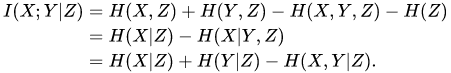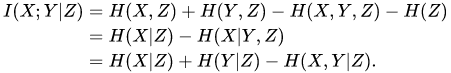

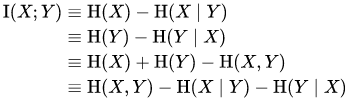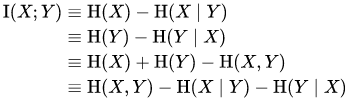

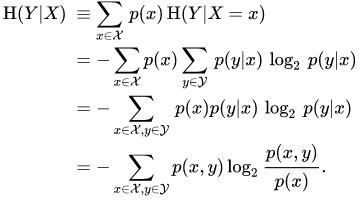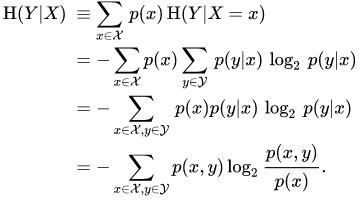

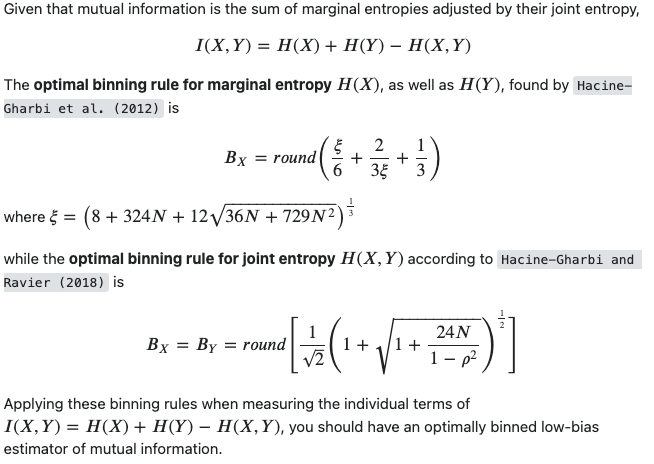

In [ ]:
def calc_bin_size_marginal(X):
    N = X.shape[0]
    ee = np.cbrt(8 + 324*N + 12*np.sqrt(36*N + 729*N**2))
    bins = np.round(ee/6 + 2/(3*ee) + 1/3)

    return int(bins)

def calc_bin_size_joint(X):
    N = X.shape[0]
    p = np.corrcoef(X.T)[0,1]
    bins = int((1/np.sqrt(2))*(1+np.sqrt(1+(24*N)/(1-p**2)))**(1/2))
    return bins


In [18]:
from sklearn.utils import check_array
from functools import partial
def ensure2d(arr):
    if arr.ndim == 1:
        return arr.reshape(-1,1)
    else:
        return arr
    
def mutual_information(
    x1,
    x2,
    conditional=None,        
    n_bins = "auto",
    check_categorical = False,
    normalize_dists = False,
    normalize_mi = False,
):
    
    x1 = ensure2d(x1)
    x2 = ensure2d(x2)
    x1 = check_array(x1, accept_sparse = False, ensure_min_samples = 2)
    x2 = check_array(x2, accept_sparse = False, ensure_min_samples = 2)
        
    if isinstance(n_bins, str):
        if not n_bins == "auto":
            raise ValueError(f"n_bins should be int or 'auto', got {n_bins}")    
        
    if n_bins == "auto":
        nbins_marginal = calc_bin_size_marginal(x1)
        nbins_joint = calc_bin_size_joint(np.hstack([x1,x2]))
    else:
        nbins_marginal = n_bins
        nbins_joint = n_bins
                                        
    if not conditional is None:
        entropy_func = partial(conditional_entropy, check_categorical = check_categorical, normalize_dists = normalize_dists)
        
        conditional = ensure2d(conditional)
        conditional = check_array(conditional, accept_sparse = False, ensure_min_samples = 2)        
        
        Hx1cz, maxHx1cz = entropy_func(x1,conditional, bins = nbins_marginal)
        Hx2cz, maxHx2cz = entropy_func(x2,conditional, bins = nbins_marginal)
        Hx1x2cz, _ = entropy_func(np.hstack([x1,x2]),conditional, bins = nbins_joint)
                                
        mi = Hx1cz + Hx2cz - Hx1x2cz
                
        norm_factor = (maxHx1cz+maxHx2cz)/2
        
    else:                
        entropy_func = partial(entropy, check_categorical = check_categorical, normalize_dists = normalize_dists)
        Hx1, maxHx1 = entropy_func(x1, bins = nbins_marginal)
        Hx2, maxHx2 = entropy_func(x2, bins = nbins_marginal)
        Hx1x2, _ = entropy_func(np.hstack([x1,x2]), bins = nbins_joint)
        
        mi = Hx1 + Hx2 - Hx1x2
        
        norm_factor = (maxHx1+maxHx2)/2#(np.log(np.prod(b1)) + np.log(np.prod(b2)))
        
    if normalize_mi:
        mi = mi/norm_factor
        
    return max(0,mi)
    
    
    
    
    

In [19]:
def conditional_entropy(X,Y, bins = 100, check_categorical = False, normalize_dists = False, both_sides = False):
    
    
    X = ensure2d(X)
    X = check_array(X, accept_sparse = False, ensure_min_samples = 2)                    
    Y = ensure2d(Y)
    Y = check_array(Y, accept_sparse = False, ensure_min_samples = 2)                    
        
    has_saved_cat_cols_X = False
    has_saved_cat_cols_Y = False
    
    if check_categorical:
                        
        X_bins = (bins*np.ones(X.shape[-1])).astype(int)        
        iterator = range(X.shape[-1])
        saved_cat_cols_X = []
        cat_ixs_X = []
        for jj in iterator:
            n_unique = len(np.unique(X[:,jj]))
            if n_unique <= bins:
                X_bins[jj] = n_unique           
                cat_ixs_X.append(jj)
                saved_cat_cols_X.append(X[:,jj])
        
        if saved_cat_cols_X:
            has_saved_cat_cols_X = True

        X_bins = list(X_bins)                            
        
        #Y
        Y_bins = (bins*np.ones(Y.shape[-1])).astype(int)
        iterator = range(Y.shape[-1])
        saved_cat_cols_Y = []
        cat_ixs_Y = []
        for jj in iterator:
            n_unique = len(np.unique(Y[:,jj]))
            if n_unique <= bins:
                Y_bins[jj] = n_unique           
                cat_ixs_Y.append(jj)
                saved_cat_cols_Y.append(Y[:,jj])
        
        if saved_cat_cols_Y:
            has_saved_cat_cols_Y = True
        
        Y_bins = list(Y_bins)
    

    if normalize_dists:
        X = KBinsDiscretizer(bins, encode = "ordinal",strategy = "quantile").fit_transform(X)
        Y = KBinsDiscretizer(bins, encode = "ordinal",strategy = "quantile").fit_transform(Y)
    
    if has_saved_cat_cols_X:
        for ix,val in zip(cat_ixs_X,saved_cat_cols_X):
            X[:,ix] = val                
    
    if has_saved_cat_cols_Y:
        for ix,val in zip(cat_ixs_Y,saved_cat_cols_Y):
            Y[:,ix] = val                
                
    XY = np.hstack([X,Y])
    
    if not has_saved_cat_cols_X:
        X_bins = (bins*np.ones(X.shape[-1])).astype(int)
        X_bins = list(X_bins)
    
    if not has_saved_cat_cols_Y:
        Y_bins = (bins*np.ones(Y.shape[-1])).astype(int)
        Y_bins = list(Y_bins)
        
        
    #px = np.histogramdd(X, bins = X_bins)[0]
    py = np.histogramdd(Y, bins = Y_bins)[0]
    
    pxy = np.histogramdd(XY, bins = X_bins+Y_bins)[0]
    
    #px = np.where(px==0,1e-15,px)
    py = np.where(py==0,1e-15,py)
    pxy = np.where(pxy==0,1e-15,pxy)
    
    #px = px/px.sum()
    pxy = pxy/pxy.sum()
    py = py/py.sum()
    
    Hxy = np.sum(-pxy*np.log(pxy))
    Hy = np.sum(-py*np.log(py))
    #Hx = np.sum(-px*np.log(px))
    
    Hxcy = Hxy - Hy
    #Hycx = Hxy - Hx
    max_entropy = np.log(len(pxy.flatten()))
    return max(0,Hxcy), max_entropy

In [20]:
def entropy(X, bins = 100, check_categorical = False, categorical_indexes=[], normalize_dists = False):
    
    
    X = ensure2d(X)
    X = check_array(X, accept_sparse = False, ensure_min_samples = 2)                    
        
    saved_cat_cols = None
    if check_categorical or categorical_indexes:
        bins_ = bins
        bins = (bins*np.ones(X.shape[-1])).astype(int)
        
        iterator = categorical_indexes if len(categorical_indexes)>0 else range(X.shape[-1])
        saved_cat_cols_ = []
        cat_ixs = []
        for jj in iterator:
            n_unique = len(np.unique(X[:,jj]))
            if n_unique <= bins_:
                bins[jj] = n_unique           
                cat_ixs.append(jj)
                saved_cat_cols_.append(X[:,jj])
        
        if saved_cat_cols_:
            saved_cat_cols = saved_cat_cols_
        bins = list(bins)
    

    if normalize_dists:
        X = KBinsDiscretizer(bins, encode = "ordinal",strategy = "quantile").fit_transform(X)
    
    if saved_cat_cols:
        for ix,val in zip(cat_ixs,saved_cat_cols_):
            X[:,ix] = val                
                
    counts = np.histogramdd(X, bins = bins)[0]    
    if not hasattr(bins, "__len__"):
        bins = [bins]
    
    counts = counts.flatten()
    counts = np.where(counts==0, 1/len(counts), counts)
    p = (counts/counts.sum())    
    entr = np.sum(-p*np.log(p))
    max_entropy = np.log(len(p.flatten()))
    return max(0,entr), max_entropy

# Data

In [21]:
n = 10_000
# X = np.random.randn(n)
# Y = X**2 + np.random.randn(n)
# Z = X*Y + 10*np.random.binomial(1,0.3, n)

X = np.random.randn(n)
Y = np.random.randn(n)
Z = X + Y# + 10*np.random.binomial(1,0.3, n)


In [22]:
XY = np.array([X,Y]).T
XZ = np.array([X,Z]).T
YZ = np.array([Y,Z]).T
XYZ = np.array([X,Y,Z]).T

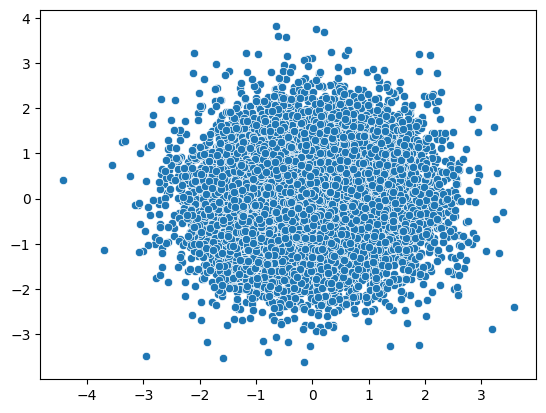

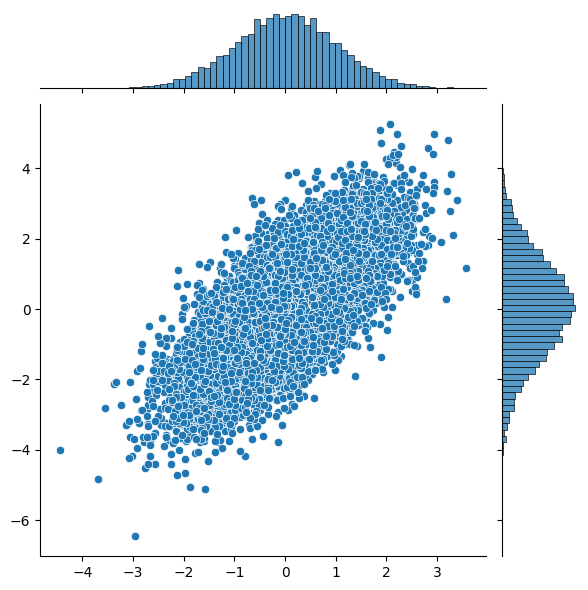

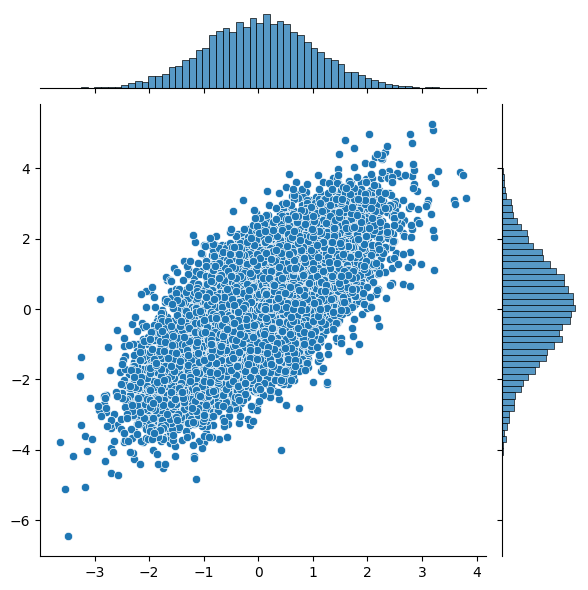

In [23]:
sns.scatterplot(x=X,y=Y)
sns.jointplot(x=X,y=Z)
sns.jointplot(x=Y,y=Z)


In [24]:
from scipy import stats

In [25]:
dist = stats.multivariate_normal(mean = [0,0], cov = [1,1])
uniform = stats.uniform(0,5)

In [29]:
dist.entropy(), entropy(dist.rvs(10000),bins = 100, normalize_dists = True)

(2.8378770664093453, (8.64137408509984, 9.210340371976184))

In [233]:
uniform.entropy(), entropy(uniform.rvs(10000),bins = 100, normalize_dists = True)

(array(1.60943791), (4.60517018598809, 4.605170185988092))

In [234]:
n = 100_000
X = np.random.randn(n)
Y = np.random.randn(n)
cat = np.random.binomial(1, 0.3, size = n)
Z = X + Y#+ 10*np.random.binomial(1,0.3, n)

In [235]:
XY = np.array([X,Y]).T
XZ = np.array([X,Z]).T
YZ = np.array([Y,Z]).T
Ycat = np.array([Y,cat]).T
XYZ = np.array([X,Y,Z]).T

# Test

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
%%timeit -n 3 -r 3
n=10_000
DecisionTreeClassifier().fit(np.random.randint(0,10,(n,2)),np.random.randint(0,5, n))


5.12 ms ± 977 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [30]:
%%timeit -n 3 -r 3
n=10_000
mutual_information(np.random.randn(n),np.random.randn(n),np.random.randn(n),)

9.14 ms ± 446 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [31]:
%%timeit -n 3 -r 3
n=100_000
mutual_information(np.random.randn(n),np.random.randn(n),np.random.randn(n),)

56 ms ± 5.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [39]:
mutual_information(X,Y, normalize_dists = True, n_bins = 100, check_categorical=True, normalize_mi = True)

0.12161375884484145

In [41]:
mutual_information(X,Y,Z, normalize_dists = True, n_bins = 100, check_categorical=True, normalize_mi = True)

0.36200876061048964

In [240]:
mutual_information(Z,Y,X, normalize_dists = True, n_bins = 100, check_categorical=True)

3.6512200841885782

In [244]:
entropy(np.random.randn(1000,2), normalize_dists = False)[0], entropy(np.random.randn(1000,1), normalize_dists = False)[0]

(6.717423930208982, 4.118630346800489)

In [544]:
!pip install statsmodels

     |████████████████████████████████| 9.7 MB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 5.0 MB/s eta 0:00:01


In [550]:
import statsmodels.api as sm

In [554]:
sm.nonparametric.KDEMultivariateConditional(XY, Z, "cc", "c", "cv_ml")


KeyboardInterrupt



In [ ]:
def conditional_entropy():
    -np.sum(p(x,y))